# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral learning

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

## Credits
List of websites / repositories that helped reach this solution:
* Shadow idea: https://github.com/navoshta/behavioral-cloning
* Generator: https://github.com/MarkBroerkens/CarND-Behavioral-Cloning-P3

## Imports

In [1]:
# Environment
# Python 3.5
# TensorFlow 1.1.0
# OpenCV
# MatPlotLib
# Numpy

from os import getcwd, listdir # Listing files
from os.path import isfile, dirname, join # Checking if file is file or directory / building file path
import cv2 # Reading images and images operations
import csv # Images vehicle data
import random # Random image display
import matplotlib.pyplot as plt # All plots


import math # For generic math operations
import numpy as np

#import tensorflow
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


---
## Step 0: Load the data

In [2]:
from IPython.display import clear_output


driving_log_path = 'data/driving_log.csv'

def load_driving_data(driving_log_path, header=True, delimiter=',', sa_lr_corr=0.2, verbose=True):
    # Images path is expected to be relative to the driving data directory
    lines=0
    imgs=None
    snsrs=None
    
    with open(driving_log_path, 'r') as driving_log_file:
        # Retrieve log directory
        driving_log_dir = dirname(driving_log_path)        
        reader = csv.reader(driving_log_file, delimiter=delimiter)
        for line in reader:
            if(reader.line_num % 100 == 0):
                clear_output(wait=True)
                print("Reading line {}".format(reader.line_num), flush=True)
            if header:
                header = False
                continue
            
            lines = lines + 1
            # Center, Left, Right images
            img_cntr_path = join(driving_log_dir, line[0].strip())
            img_left_path = join(driving_log_dir, line[1].strip())
            img_right_path = join(driving_log_dir, line[2].strip())
                    
            #Not opening images because too long to load from disk
            #img_cntr = np.asarray(cv2.imread(img_cntr_path))
            #img_left = np.asarray(cv2.imread(img_left_path))
            #img_right = np.asarray(cv2.imread(img_right_path))
            
            # Sensor data: Sensors (snsrs), Steering angle (sa), throttle (thr), brake (brk), speed (spd)
            sa_cntr = float(line[3])
            #thr = float(line[4])
            #brk = float(line[5])
            #spd = float(line[6])
            # Adjusted steering angle for left and right images
            sa_left = min(sa_cntr + sa_lr_corr, 1.0) # Steer to the right
            sa_right = max(sa_cntr - sa_lr_corr, -1.0) # Steer to the left

            # Building images and sensors arrays
            #imgs_new = np.concatenate(([img_cntr], [img_left], [img_right]))
            imgs_new = np.concatenate(([img_cntr_path], [img_left_path], [img_right_path]))
            
            #snsrs_cntr = np.concatenate(([sa_cntr], [thr], [brk], [spd]))
            #snsrs_left = np.concatenate(([sa_left], [thr], [brk], [spd]))
            #snsrs_right = np.concatenate(([sa_right], [thr], [brk], [spd]))            
            #snsrs_new = np.concatenate(([snsrs_cntr], [snsrs_left], [snsrs_right]))
            snsrs_new = np.concatenate(([sa_cntr], [sa_left], [sa_right]))
            
            #Image and sensors dataset
            if imgs is None:
                imgs = imgs_new
                snsrs = snsrs_new
            else:
                imgs = np.concatenate((imgs, imgs_new))
                snsrs = np.concatenate((snsrs, snsrs_new))
            
    clear_output(wait=True)
    print("Finished reading")
    return imgs, snsrs, lines

In [3]:
imgs_path, snsrs, lines = load_driving_data(driving_log_path)

Finished reading


---

## Step 1: Dataset exploration & summary

The data is an array composed of 7 values pairs:
center,left,right,steering,throttle,brake,speed
- `'center'` is the relative path to the image from the center camera of the vehicle.
- `'left'` is the relative path to the image from the center camera of the vehicle.
- `'right'` is the relative path to the image from the center camera of the vehicle.
- `'steering'` float between -1 and 1 representing the steering angle.
- `'throttle'` float between 0 and 1 representing the throttle command.
- `'brake'` float between 0 and 1 representing the brake command.
- `'speed'` float between representing the vehicle speed.


### 1.1 Basic Summary of the dataset

In [4]:
print("Lines: {}".format(lines))
print("Images: {}".format(len(imgs_path)))
image_shape = np.asarray(cv2.imread(imgs_path[0])).shape
print("- Shape: {}".format(image_shape))

print("Sensors: {}".format(len(snsrs)))

Lines: 8036
Images: 24108
- Shape: (160, 320, 3)
Sensors: 24108


### 1.2 Visual summary of the dataset

In [5]:
# Visualizations will be shown in the notebook.
#%matplotlib inline

#### Visualize random images and vehicle data

In [6]:
def overlay_img(img, sa, sa_pred, w=320, h=160, interpolation=cv2.INTER_AREA):
    # Assuming image is RGB
    dst = cv2.resize(img, (w, h), interpolation=interpolation)
    
    # Overlay sensor information
    cv2.putText(dst, "ANGLE {}".format(sa),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                org=(4, 16), fontScale=.5,
                color=(128, 255, 128),
                thickness=1)
    
    # Overlay predicted steering angle
    if sa_pred is not None:
        cv2.putText(dst, "PRED. ANGLE {}".format(sa_pred),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            org=(4, 32), fontScale=.5,
            color=(128, 255, 128),
            thickness=1)
    return dst

def plot_imgs(imgs, snsrs=None, snsrs_pred=None, header=None, gray=False, imgs_limit=12):
    # Prevent long processing time if not explicitely asked by setting display limit
    if(imgs_limit > len(imgs)):
        imgs_limit = len(imgs)
    
    # Determine size of subplots matrix
    figsize=(20,3.5)
    cols=3
    rows = math.ceil(imgs_limit/cols)    
    fig, axs = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    
    # Transform matrix of subplots to a flattened one-dimensional array
    axs = axs.ravel()
    
    # Display each image in subplots
    for i in range(imgs_limit):
        # Remove axis as we are displaying images
        axs[i].axis('off')

        # Collect image sensors information if vailable
        snsr=""
        if snsrs is not None:
            snsr=snsrs[i]

        snsr_pred=""
        if snsrs_pred is not None:
            snsr_pred=snsrs_pred[i]

        # Build overlayed image
        img = overlay_img(imgs[i], snsr, snsr_pred)

        # Display image and title
        if(gray):                
            axs[i].imshow(img, cmap='gray')
        else:
            axs[i].imshow(img)
        title = ""
        if header is not None:
            title = header[i]
        axs[i].set_title(title, fontsize=12)

    # Hide unused subplots
    while i < len(axs):
        axs[i].axis('off')
        i = i + 1
    plt.show()

# Plot random images
def plot_imgs_path_rand(imgs_path, snsrs, gray=False, imgs_limit=50):
    # List of randomly picked images and their sensors value
    imgs_rand = []
    snsrs_rand = [] 
        
    # For each unique label in available images
    for i in range(imgs_limit):
        # Pick a random image in the dataset
        img_rand_id = np.random.choice(len(imgs_path))
        img_rand = cv2.cvtColor(cv2.imread(imgs_path[img_rand_id]), cv2.COLOR_BGR2RGB)
        imgs_rand.append(img_rand)
        snsrs_rand.append(snsrs[img_rand_id])

    plot_imgs(imgs_rand,snsrs_rand, gray=gray, imgs_limit=imgs_limit)

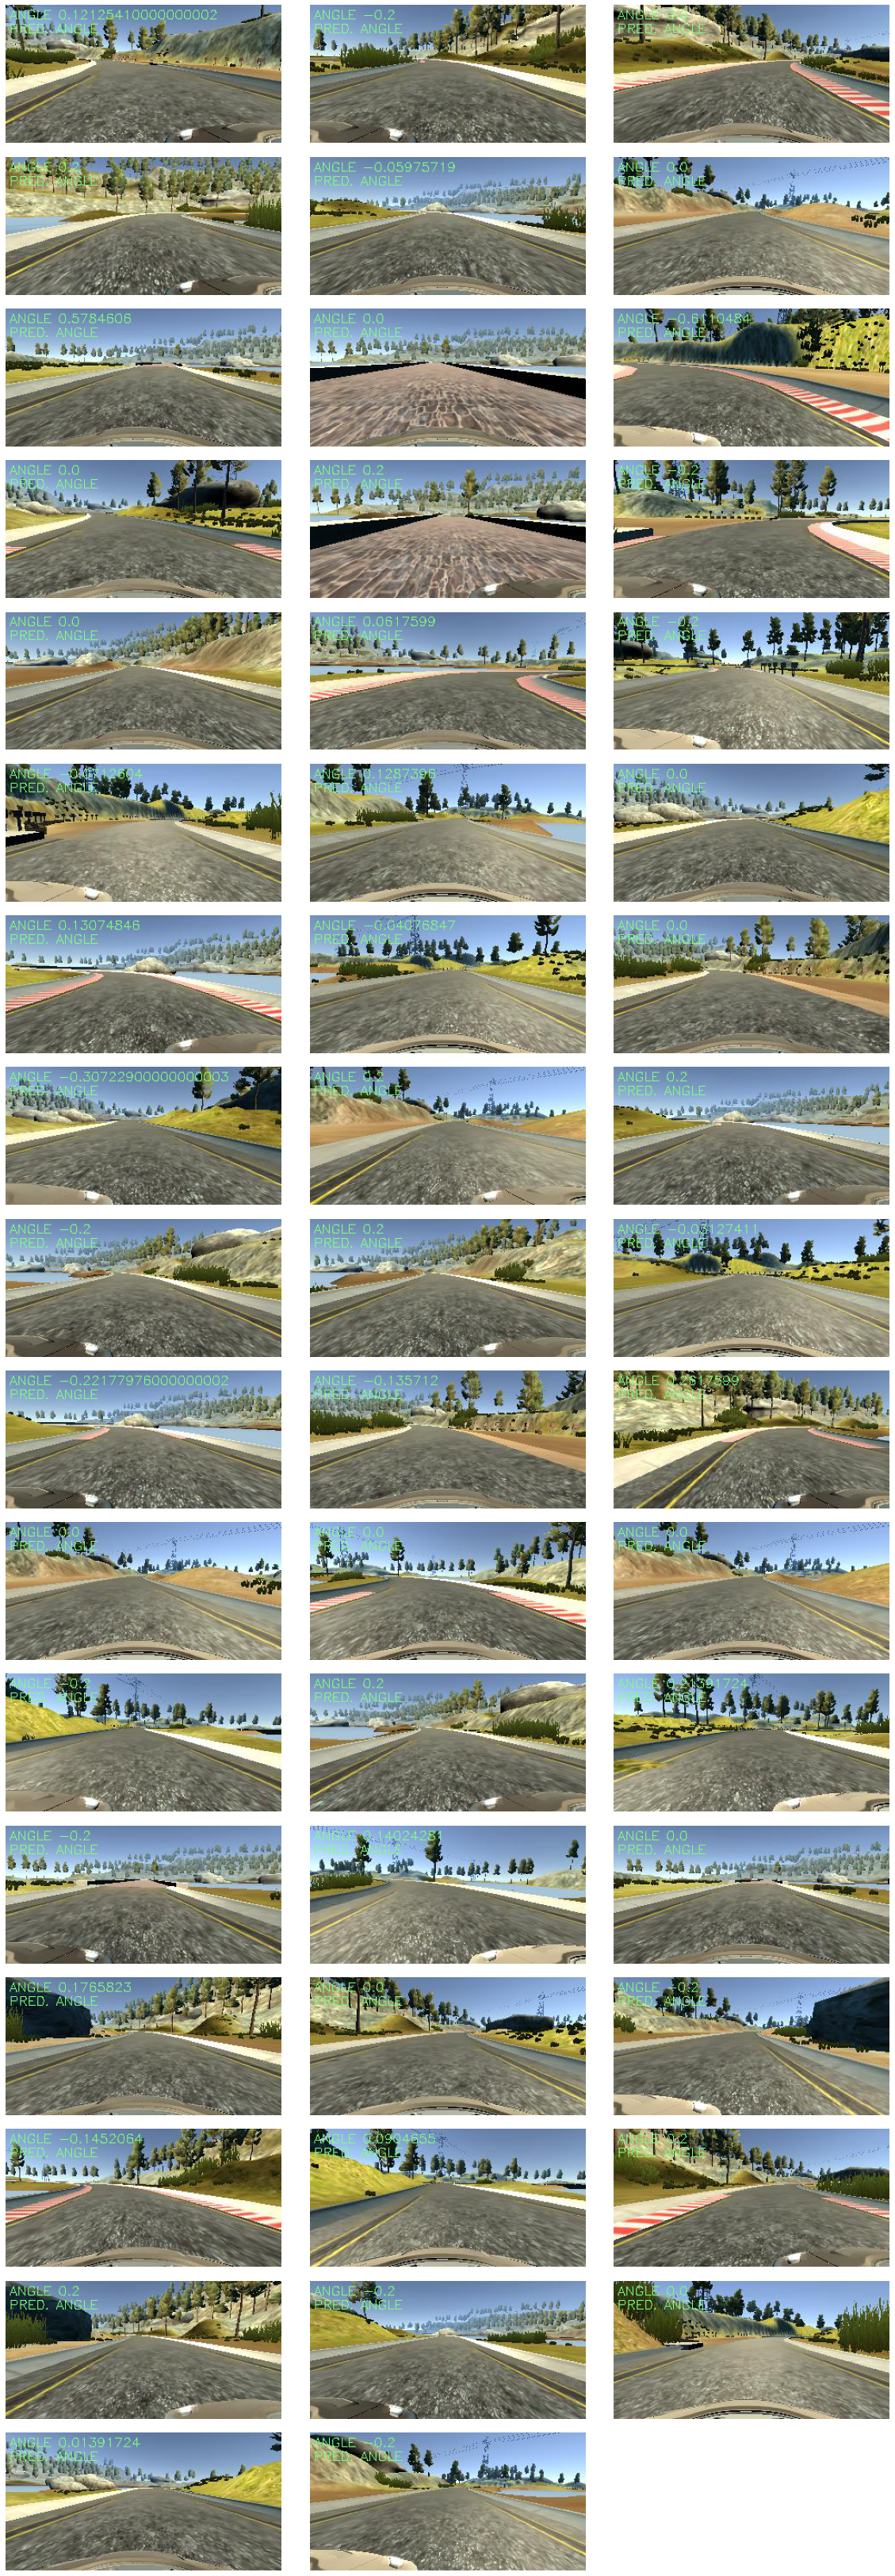

In [7]:
plot_imgs_path_rand(imgs_path, snsrs)

#### Analyze arrangement of training data

In [8]:
range_step = 5
range_bins = math.ceil(200/range_step)
# Bar chart with repartition of data depending on steering angle
print("    Steering angle range occurences count:")
for sa_range in range(-100, 100, range_step):
    # Determine range
    min_range=sa_range/100
    max_range=(sa_range+range_step)/100
    
    # Determine range
    snsrs_range = snsrs    
    if(max_range == 1.0):
        # Include 1.0 in the range    
        snsrs_range = np.where((snsrs_range >= min_range) & (snsrs_range <= max_range))[0]
        print("    [{0:5};{1:5}] = ({2:<5})    -->".format(min_range, max_range, len(snsrs_range)), end='')
    else:
        snsrs_range = np.where((snsrs_range >= min_range) & (snsrs_range < max_range))[0]
        print("    [{0:5};{1:5}[ = ({2:<5})    -->".format(min_range, max_range, len(snsrs_range)), end='')
    
    if sa_range%15 == 0:
        print("")

    Steering angle range occurences count:
    [ -1.0;-0.95[ = (6    )    -->    [-0.95; -0.9[ = (5    )    -->    [ -0.9;-0.85[ = (2    )    -->
    [-0.85; -0.8[ = (5    )    -->    [ -0.8;-0.75[ = (1    )    -->    [-0.75; -0.7[ = (16   )    -->
    [ -0.7;-0.65[ = (12   )    -->    [-0.65; -0.6[ = (57   )    -->    [ -0.6;-0.55[ = (38   )    -->
    [-0.55; -0.5[ = (53   )    -->    [ -0.5;-0.45[ = (152  )    -->    [-0.45; -0.4[ = (216  )    -->
    [ -0.4;-0.35[ = (166  )    -->    [-0.35; -0.3[ = (396  )    -->    [ -0.3;-0.25[ = (745  )    -->
    [-0.25; -0.2[ = (455  )    -->    [ -0.2;-0.15[ = (4804 )    -->    [-0.15; -0.1[ = (832  )    -->
    [ -0.1;-0.05[ = (1009 )    -->    [-0.05;  0.0[ = (910  )    -->    [  0.0; 0.05[ = (4830 )    -->
    [ 0.05;  0.1[ = (889  )    -->    [  0.1; 0.15[ = (970  )    -->    [ 0.15;  0.2[ = (821  )    -->
    [  0.2; 0.25[ = (4716 )    -->    [ 0.25;  0.3[ = (572  )    -->    [  0.3; 0.35[ = (381  )    -->
    [ 0.35;  0.4[ = (584  )   

In [9]:
def plot_dataset_snsrs(snsrs):
    plt.figure(figsize=(20, 15)) 

    gs = plt.GridSpec(3, 3)
    ax11 = plt.subplot(gs[0, :])
    ax21 = plt.subplot(gs[1, 0])
    ax22 = plt.subplot(gs[1, 1])
    ax23 = plt.subplot(gs[1, 2])
    ax31 = plt.subplot(gs[2, :])

    ax11.pcolor([snsrs], cmap = 'RdYlGn', vmin=-1., vmax=1.)
    ax11.set_title("Repartition of the {} steering angles".format(len(snsrs)), fontsize=18)
    ax11.tick_params(axis='both', which='major', labelsize=13)
    ax11.get_yaxis().set_visible(False)

    zoom_l = 0
    zoom_r = int(len(snsrs)/100)
    ax21.pcolor([snsrs[zoom_l:zoom_r]], cmap = 'RdYlGn', vmin=-1., vmax=1.)
    ax21.set_title("Zoom x100", fontsize=18)
    ax21.tick_params(axis='both', which='major', labelsize=13)
    ax21.get_yaxis().set_visible(False)

    zoom_l = int(zoom_r/2)
    zoom_r = int(zoom_l+(len(snsrs))/200)
    ax22.pcolor([snsrs[zoom_l:int(2*len(snsrs)/200)]], cmap = 'RdYlGn', vmin=-1., vmax=1.)
    ax22.set_title("Zoom x200", fontsize=18)
    ax22.tick_params(axis='both', which='major', labelsize=13)
    ax22.get_yaxis().set_visible(False)

    zoom_l = zoom_l
    zoom_r = int(zoom_l+len(snsrs)/400)
    ax23.pcolor([snsrs[zoom_l:zoom_r]], cmap = 'RdYlGn', vmin=-1., vmax=1.)
    ax23.set_title("Zoom x400", fontsize=18)
    ax23.tick_params(axis='both', which='major', labelsize=13)
    ax23.get_yaxis().set_visible(False)
    
    ax31.hist(snsrs, bins=range_bins, rwidth=0.75, color="Grey")

    plt.show()

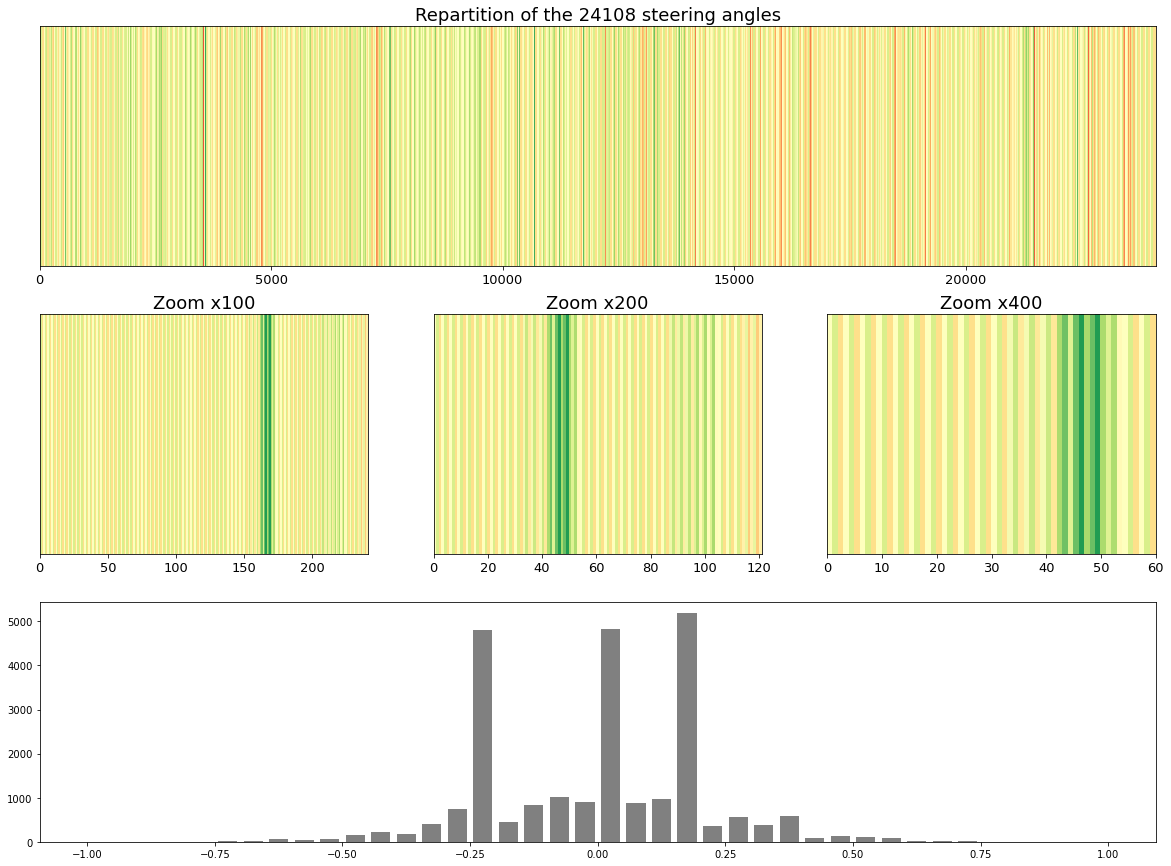

In [10]:
plot_dataset_snsrs(snsrs)

----

## Step 2: Pre-process dataset

### Pre-process the dataset

#### Load images

In [11]:
def load_imgs_path(imgs_path):
    imgs = None
    for i, img_path in enumerate(imgs_path):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        if imgs is None:
            imgs = np.asarray([img])
        else:
            imgs = np.concatenate((imgs, [img]))
            
        if(i % 100 == 0):
            clear_output(wait=True)
            print("Loading image {}".format(i), flush=True)
        if(i > 1000):
            break
    clear_output(wait=True)
    print("Finished loading images")
    return imgs        

#### Crop  images
Crop images to remove irrelevant information from the FOV

#### Resize images
Resize images to match the model input layer

In [12]:
def resize_img(img, w=320, h=160, interpolation=cv2.INTER_AREA):
    dst = cv2.resize(img, (w, h),  interpolation=interpolation)
    return dst

#### Augment dataset
Augmentation methods used:
* Random horizontal / vertical translate
 * NOT USED: Not relevant as it would modify road position on image
* Random rotate (almost same result as perspective warp would do)
 * NOT USED: Not relevant as it would modify road position on image
* Random scale (zoom/unzoom)
 * NOT USED: Not relevant, would only be helful if road changed in width
* Random perspective warp (as used in lane finding)
 * NOT USED: Not relevant, would modify road curvature (affects steering angle) and scale (see scale comment)
* Random colors change
 * More relevant as we want to ignore road surface and road side type

In [13]:
def rand_hsv_channel(img, channel, shift=64):
    rows,cols,_ = img.shape
        
    # Transform image to HSV to easily manipulate brightness/saturation
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Allow channel shift to be between -shift to +shift V
    d_shift = np.random.randint(-shift,shift)
    hsv[:,:,channel] = cv2.add(hsv[:,:,channel],d_shift)    
    dst = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return dst

def rand_hsv_h(img, shift=64):
    return rand_hsv_channel(img, 0, shift=64)
def rand_hsv_s(img, shift=64):
    return rand_hsv_channel(img, 1, shift=64)
def rand_hsv_v(img, shift=64):
    return rand_hsv_channel(img, 2, shift=64)

In [14]:
def rand_transform(img):
    # Translate, Change perspective (can result in zoom in or out or even rotation), Brightness adjust
    return rand_hsv_h(rand_hsv_s(rand_hsv_v(img)))

def augment_snsrs(imgs_path, snsrs, min_count=750):
    range_step=5
    
    # Assuming RGB images for shape
    rand_imgs_path = []
    rand_snsrs = []
    
    # For steering angle range
    for sa_range in range(-100, 100, range_step):
        # Augment any data up to min_count if necessary
        min_range=sa_range/100
        max_range=(sa_range+range_step)/100

        snsrs_range = snsrs        
        if(max_range == 1.0):
            # Include 1.0 in the range    
            snsrs_range = np.where((snsrs_range >= min_range) & (snsrs_range <= max_range))[0]
        else:
            snsrs_range = np.where((snsrs_range >= min_range) & (snsrs_range < max_range))[0]
        
        snsrs_count = len(snsrs_range)
        if snsrs_count == 0:
            print("Range [{0:4};{1:4}] is not represented!".format(min_range, max_range))
            continue
        
        snsrs_augment = min_count - snsrs_count
        if snsrs_augment > 0:
            if(max_range == 1.0):
                print("Range [{0:4};{1:4}] requires {2} augmentations".format(min_range, max_range, snsrs_augment))
            else:
                print("Range [{0:4};{1:4}[ requires {2} augmentations".format(min_range, max_range, snsrs_augment))
            # Add as many augmented images as necessary
            for i in range(snsrs_augment):
                # Pick images one after the other, and loop if necessary
                rand_imgs_path.append(imgs_path[snsrs_range[i % snsrs_count]])
                rand_snsrs.append(snsrs[snsrs_range[i % snsrs_count]])
        else:
            if(max_range == 1.0):
                print("Range [{0:4};{1:4}[ does not require augmentation".format(min_range, max_range))
            else:
                print("Range [{0:4};{1:4}[ does not require augmentation".format(min_range, max_range))
            pass

    return rand_imgs_path, rand_snsrs

Range [-1.0;-0.95[ requires 744 augmentations
Range [-0.95;-0.9[ requires 745 augmentations
Range [-0.9;-0.85[ requires 748 augmentations
Range [-0.85;-0.8[ requires 745 augmentations
Range [-0.8;-0.75[ requires 749 augmentations
Range [-0.75;-0.7[ requires 734 augmentations
Range [-0.7;-0.65[ requires 738 augmentations
Range [-0.65;-0.6[ requires 693 augmentations
Range [-0.6;-0.55[ requires 712 augmentations
Range [-0.55;-0.5[ requires 697 augmentations
Range [-0.5;-0.45[ requires 598 augmentations
Range [-0.45;-0.4[ requires 534 augmentations
Range [-0.4;-0.35[ requires 584 augmentations
Range [-0.35;-0.3[ requires 354 augmentations
Range [-0.3;-0.25[ requires 5 augmentations
Range [-0.25;-0.2[ requires 295 augmentations
Range [-0.2;-0.15[ does not require augmentation
Range [-0.15;-0.1[ does not require augmentation
Range [-0.1;-0.05[ does not require augmentation
Range [-0.05; 0.0[ does not require augmentation
Range [ 0.0;0.05[ does not require augmentation
Range [0.05; 0.1[ does

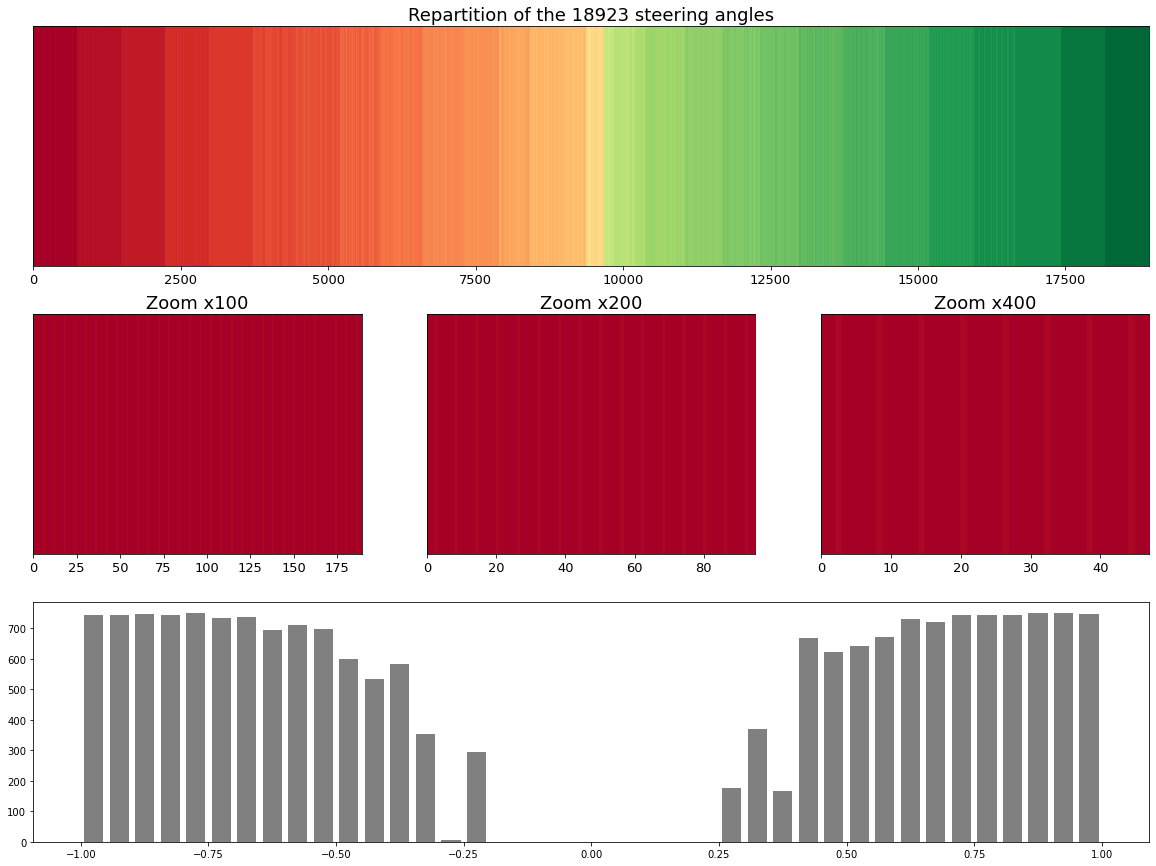

In [15]:
rand_imgs_path, rand_snsrs = augment_snsrs(imgs_path, snsrs)
plot_dataset_snsrs(rand_snsrs)

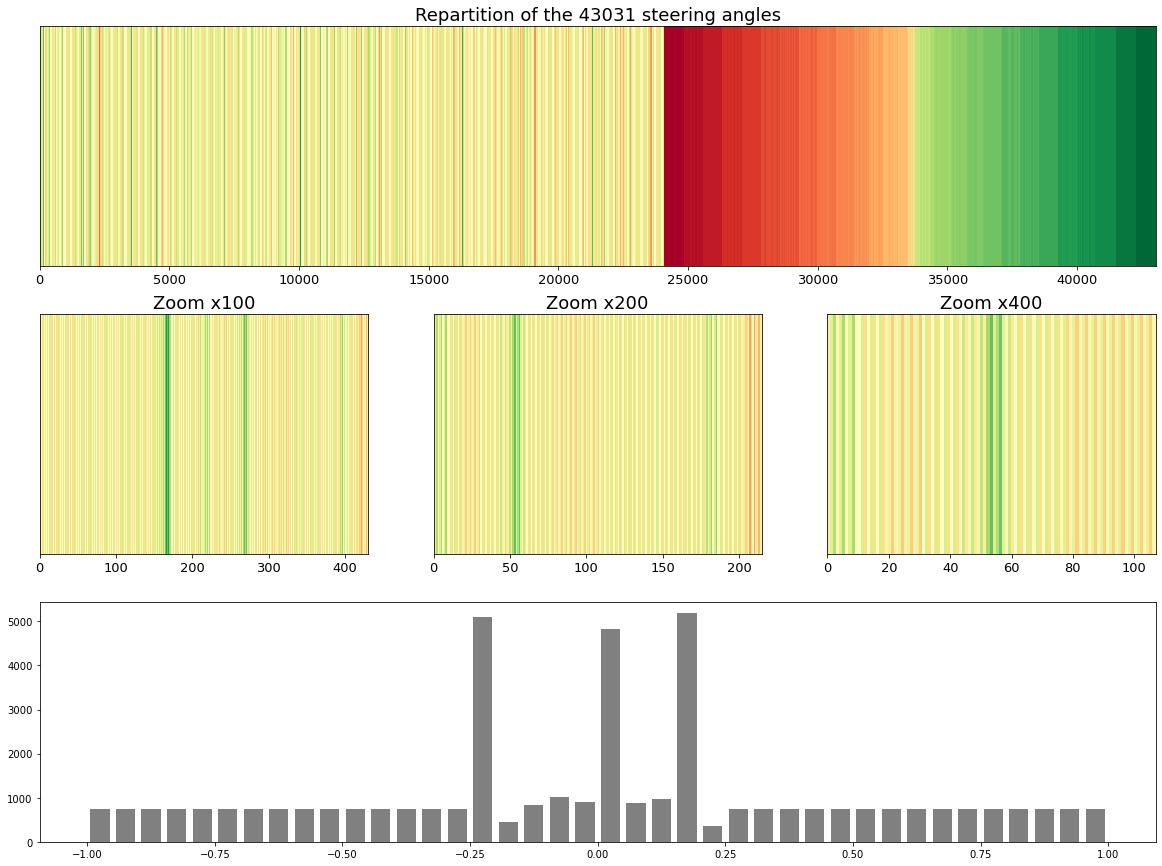

In [16]:
augmented_imgs_path = np.concatenate((imgs_path, rand_imgs_path))
augmented_snsrs = np.concatenate((snsrs, rand_snsrs))
# Create a flag for randomizing image during training
augmented_rand_flag = np.concatenate((np.zeros_like(snsrs), np.ones_like(rand_snsrs)))

plot_dataset_snsrs(augmented_snsrs)

#### Shuffle data
Shuffle the set so that no drift occurs after many successions of the same sign during the learning

In [17]:
def UnisonShuffle(a, b, c):
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]


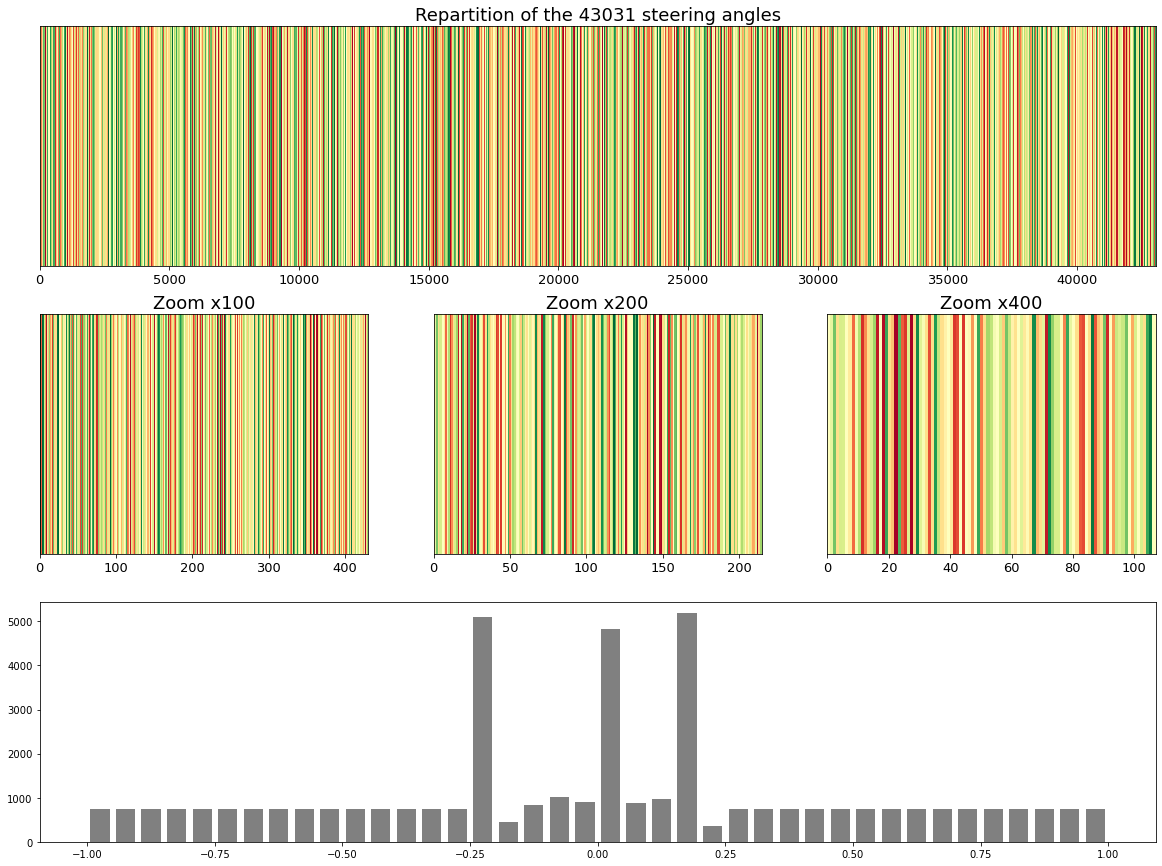

In [18]:
shuffled_imgs_path, shuffled_snsrs, shuffled_rand_flag = UnisonShuffle(augmented_imgs_path, augmented_snsrs, augmented_rand_flag)

plot_dataset_snsrs(shuffled_snsrs)

#### Gaussian blur
Gaussian blur to reduce the noise / smooth image and remove unnecessary edges and keep the most prominent edges

In [ ]:
def gaussian_blur(img, ksize=3):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (ksize, ksize), 0)

#### Grayscale images

In [ ]:
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python/45338831
def rgb_2_gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

#### Normalize images grayscale from [0; 255] to [ -1; 1 ]
Normalize data to obtain a mean close to 0 and try to speed up learning and reach faster convergence

In [ ]:
def normalize_gray(imgs, max=255):
    # Subtract half the max (256) value to center around 0 then divide by the same value to obtain a [-1;1] range
    half = max/2.0
    return (imgs - half)/half

#### Split and shuffle dataset: Train, Valid, Test
Shuffle the dataset so that no drift occurs after many successions of the same steering angle or steering angle pattern during the learning

**Note:** Some images might not be representative of the correct steering angle to apply (e.g. Images where the car is steered too much the left because of human reaction time might yield a wrong recorded versus predicted steering angle)


In [ ]:
# use 70% for training, 20% for validation and 10% for test
# random_state=1 seed to ensure shuffling produces the same result with the same data

X_train, X_valid, y_train, y_valid, r_train, r_valid =  \
    train_test_split(shuffled_imgs_path, shuffled_snsrs, shuffled_rand_flag, test_size=0.2, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test, r_train, r_test =  \
    train_test_split(X_train, y_train, r_train, test_size=0.125, random_state=1)



In [ ]:
plot_dataset_snsrs(y_train)

In [ ]:
plot_dataset_snsrs(y_test)

In [ ]:
plot_dataset_snsrs(y_valid)

----

## Step 3: Create model architecture

The model architecture is based on the [NVidia architecture](https://classroom.udacity.com/nanodegrees/nd013/parts/168c60f1-cc92-450a-a91b-e427c326e6a7/modules/95d62426-4da9-49a6-9195-603e0f81d3f1/lessons/3fc8dd70-23b3-4f49-86eb-a8707f71f8dd/concepts/7f68e171-cf87-40d2-adeb-61ae99fe56f5)

In [ ]:
def model_nVidia():
    model = Sequential()
    
    # Crop irrelevant data from FOV
    model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
    
    # Normalize and center (using lambda) (after crop to save resources)
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    
    # Nvidia model
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu"))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))
    model.add(Dense(1))
    
    return model

 Use a generator to load images little by little and prevent memory overflow

In [ ]:
# Assumes sample = {path, angle, rand_flag}
def generator(samples_paths, samples_angles, samples_rand_flags, batch_size):
    samples_count = len(samples_paths)
    
    while True: 
        # Shuffle sample for each EPOCH
        sklearn.utils.shuffle(samples)
        
        # For each batch sized slice available from the samples
        for offset in range(0, samples_count, batch_size):
            # Retrieve batch samples
            batch_paths = samples_paths[offset:offset + batch_size]
            batch_angles = samples_angles[offset:offset + batch_size]
            batch_rand_flags = samples_rand_flags[offset:offset + batch_size]
            
            images = []
            angles = []
            
            # For each sample in the batch
            for i in range(0, len(batch_paths)):
                # Read image
                image = cv2.cvtColor(cv2.imread(batch_paths[i]), cv2.COLOR_BGR2RGB)
                # Apply random transformations if flagged
                if(batch_rand_flags[i] > 0):
                    image = rand_transform(image)                
                images.append(image)
                angles.append(batch_angles[i])
           
            # Transform arrays to np arrays
            X = np.array(images)
            y = np.array(angles)
            yield X, y
    return

## Step 4: Train, validate and test model

In [ ]:
# Hyper parameters
EPOCHS=5
BATCH_SIZE=32

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(r_train))
print(X_train[0])
print(y_train[0])
print(r_train[0])

In [ ]:
# Data to be used
#X_train, X_test, X_valid
#y_train, y_test, y_valid
#r_train, r_test, r_valid

# Generators for training and validation data

train_generator = generator(X_train, y_train, r_train, batch_size=BATCH_SIZE)

valid_generator = generator(X_valid, y_valid, r_valid, batch_size=BATCH_SIZE)

# Load model
model = model_nVidia()

# Train model
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch=len(X_train)/BATCH_SIZE, validation_data=valid_generator, validation_steps=len(X_valid)/BATCH_SIZE, epochs=EPOCHS, verbose=1)

# Save model
model.save('model.h5')

#### Setup TensorFlow

#### Trials & Results

##### 1. NVidia architecture
1. 1st Training
  * Picked 10 epochs which is overkill according to instructions, should use 5
  * Inverted validation / test sets length
  * Each epoch takes around 1h30min to train on my computer with basic graphics card
  * Used wrong Keras version compared to Udacity VM (2.3.1 instead of 2.2.4)
  * Create model.py file to use Udacity VM, GPU and packages version
> Could not run simulation with that model
2. 2nd Training
  * Fixed 1st training issues  
  * Switched to Keras 2 synthax for generator and Conv2D
  * Forgot to add grayscale and gaussian blur  
> Much faster training: 2min per epoch
> No issue on 1st track!
5. To do
  * Enhance dataset again?
  * Need to point Jupyter to model.py functions to avoid updating at both places
  


##### 3. Augmenting dataset